# HistGradientBoostingRegressor
Haytham Mohamed

INFS 890 - Spring 2020

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [72]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
#data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


SCALE_TARGETS = True
SCALE_FEATURES = False

FEATURES_SELECTION = False

test_split = 0.2

In [73]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [74]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)

print('data shape {}'.format(data.shape))

data.head(5)

data shape (6766, 29)


,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,...,user-db_net_use,shipping_net_use,payment_net_use,carts_net_use,carts-db_net_use,nodes_cpu_use,nodes_disk_io,nodes_net_use,orders_req,orders_ltcy
0,0.0300,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0300,0.0700,1.0000,...,2.2044,2.6585,8.9654,22.0117,4.7995,2.5000,1.6700,2.7617,0.1500,0.2400
1,0.0600,0.0200,0.0200,0.0200,0.0200,0.0100,0.0100,0.1800,0.1800,1.0000,...,2.2044,2.6585,8.9654,22.0117,4.7995,1.8900,1.0100,2.7617,0.1500,0.2400
2,0.0700,0.0300,0.0200,0.0300,0.0200,0.0100,0.0100,0.4400,0.2000,1.0000,...,16.0739,13.5708,16.9964,27.3438,16.6522,1.3500,0.0500,2.5880,0.1500,0.2400
3,0.0700,0.0300,0.0200,0.0200,0.0200,0.0100,0.0100,0.2300,0.1700,1.0000,...,19.9869,14.4342,9.5804,9.4313,17.1768,1.2600,0.0400,2.1487,0.1300,0.2400
4,0.0700,0.0200,0.0100,0.0200,0.0200,0.0100,0.0100,0.2400,0.1400,1.0000,...,10.4490,3.7392,2.7970,9.1791,6.2516,1.2800,0.2600,1.8080,0.3600,0.2400


In [75]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))


there are 28 features


In [76]:
# print out the features
for feature in inputs.columns.values:
    print(feature)

front-end_cpu_use
orders_cpu_use
orders-db_cpu_use
user_cpu_use
user-db_cpu_use
shipping_cpu_use
payment_cpu_use
carts_cpu_use
carts-db_cpu_use
front-end_pods
orders_pods
user_pods
shipping_pods
payment_pods
carts_pods
front-end_net_use
orders_net_use
orders-db_net_use
user_net_use
user-db_net_use
shipping_net_use
payment_net_use
carts_net_use
carts-db_net_use
nodes_cpu_use
nodes_disk_io
nodes_net_use
orders_req


# Features Selection

In [77]:
def features_selection(x, y, to_scale=FEATURES_SELECTION):
    if to_scale:  
        #clf = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15)    
        clf = LassoCV(tol=0.1)
        sfm = SelectFromModel(clf, threshold='0.05*mean')

        selectedFeatures = sfm.fit(x, y).transform(x)
        print('{} features selected'.format(selectedFeatures[1].shape[0]))
        
        feature_list = x.columns[sfm.get_support()]
        features = ''
        features = ', '.join(feature_list)
    
        print("columns selected are {}".format(features))

        x = x[feature_list]        
    return x


In [78]:
inputs = features_selection(inputs, targets)

In [79]:
# scale targets for better convergence
if SCALE_TARGETS:
    y_scaler =  MinMaxScaler()
    targets = y_scaler.fit_transform(targets.values.reshape(-1,1))
    
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)  

if SCALE_FEATURES:
    x_scaler = StandardScaler()
    x_train = x_scaler.fit_transform(x_train)
    x_test = x_scaler.transform(x_test)

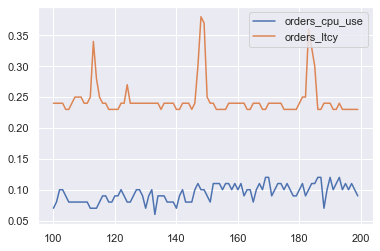

In [80]:
# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][100:200], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][100:200], label='orders_ltcy')
plt.legend()
plt.show()


# Model

In [81]:
clf = LassoCV(tol=0.1)
sfm = SelectFromModel(clf, threshold='0.05*mean')

reg = HistGradientBoostingRegressor()

pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', sfm),
    ('reg', reg)
])

kfold = KFold(n_splits=10, shuffle=False)

param_grid = {
    'selector__threshold': ['0.05*mean', '0.02*mean', '0.01*mean'], # with tree
    'reg__max_iter': [1000,1200,1500],
     'reg__learning_rate': [0.1],
     'reg__max_depth' : [25, 50, 75],
     'reg__l2_regularization': [1.5],
     'reg__scoring': ['loss'],
     'reg__random_state' : [100]
}

search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=1, n_jobs=-1)

In [82]:
for key in search.estimator.get_params().keys():
    print(key)

memory
steps
verbose
scaler
selector
reg
scaler__copy
scaler__with_mean
scaler__with_std
selector__estimator__alphas
selector__estimator__copy_X
selector__estimator__cv
selector__estimator__eps
selector__estimator__fit_intercept
selector__estimator__max_iter
selector__estimator__n_alphas
selector__estimator__n_jobs
selector__estimator__normalize
selector__estimator__positive
selector__estimator__precompute
selector__estimator__random_state
selector__estimator__selection
selector__estimator__tol
selector__estimator__verbose
selector__estimator
selector__max_features
selector__norm_order
selector__prefit
selector__threshold
reg__l2_regularization
reg__learning_rate
reg__loss
reg__max_bins
reg__max_depth
reg__max_iter
reg__max_leaf_nodes
reg__min_samples_leaf
reg__n_iter_no_change
reg__random_state
reg__scoring
reg__tol
reg__validation_fraction
reg__verbose
reg__warm_start


In [83]:
import sklearn 
print('sklearn version {}'.format(sklearn.__version__))

search.fit(x_train, y_train)

sklearn version 0.22.2.post1
Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 12.2min finished
/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selector',
                                        SelectFromModel(estimator=LassoCV(alphas=None,
                                                                          copy_X=True,
                                                                          cv=None,
                                                                          eps=0.001,
                                                                          fit_intercept=True,
                                                                          max_iter=1000,
                   

In [84]:
# Print the best parameters found
print(search.best_params_)
# Print the best scores found
print()
print(search.best_score_)

{'reg__l2_regularization': 1.5, 'reg__learning_rate': 0.1, 'reg__max_depth': 25, 'reg__max_iter': 1000, 'reg__random_state': 100, 'reg__scoring': 'loss', 'selector__threshold': '0.01*mean'}

-0.056879033852454054


# Training R2

In [85]:
y_train_pred = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_train_pred)
print('R2 (training) = {}'.format(r2_train))

print('Score (training) = {}'.format(search.score(x_train,y_train)))

R2 (training) = 0.9381912087878017
Score (training) = -0.008082588375739153


In [86]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_train_pred)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.37 (0.34) 0.00 1.00 MSE


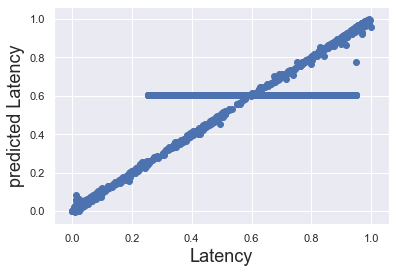

In [87]:
plt.scatter(y_train, y_train_pred)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
plt.show()

# Testing

In [88]:
y_test_pred = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

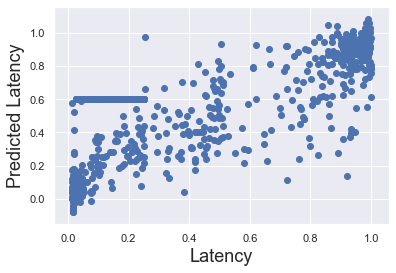

In [89]:
plt.scatter(y_test, y_test_pred)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

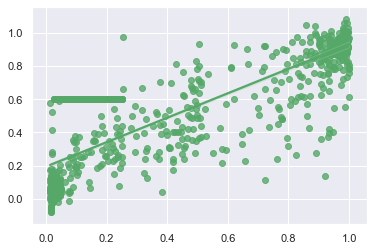

In [90]:
ax = sns.regplot(x=y_test, y=y_test_pred, color='g')

In [91]:
perf = pd.DataFrame(y_test_pred, columns=['prediction'])
perf['target'] = y_test
perf.head()

,prediction,target
0,0.6013,0.2517
1,0.6013,0.2510
2,0.6013,0.2504
3,0.6013,0.2497
4,0.6013,0.2491


In [92]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,0.6013,0.2517,0.3496,138.8828
1,0.6013,0.2510,0.3502,139.5021
2,0.6013,0.2504,0.3509,140.1246
3,0.6013,0.2497,0.3515,140.7504
4,0.6013,0.2491,0.3522,141.3794
...,...,...,...,...
1349,0.9340,0.9877,-0.0537,5.4370
1350,0.9475,0.9877,-0.0401,4.0644
1351,0.9165,0.9856,-0.0692,7.0166
1352,0.8525,0.9887,-0.1362,13.7740


In [93]:
perf.describe()

,prediction,target,residual,difference%
count,"1,354.0000","1,354.0000","1,354.0000","1,354.0000"
mean,0.4107,0.2942,0.1166,192.4894
std,0.3397,0.3593,0.2335,346.0538
min,-0.0798,0.0134,-0.7825,0.0088
25%,0.0434,0.0236,-0.0114,12.9651
50%,0.5004,0.1062,0.0175,52.1458
75%,0.6013,0.4838,0.3618,219.6844
max,1.0827,1.0000,0.7220,"3,894.3562"


In [94]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.4f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
447,0.0226,0.0226,0.0000,0.0088
1257,0.9727,0.9733,-0.0006,0.0615
1168,0.9377,0.9383,-0.0007,0.0706
1109,0.9744,0.9753,-0.0010,0.1005
1337,0.9662,0.9651,0.0011,0.1160
...,...,...,...,...
346,0.6013,0.0265,0.5747,2167.5883
347,0.6013,0.0259,0.5754,2224.6461
348,0.6013,0.0252,0.5760,2284.6494
1229,0.5252,0.0195,0.5056,2589.4051


# *** Prediction Accuracy

In [95]:
r2_test = metrics.r2_score(y_test, y_test_pred)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.4723734119532199


In [96]:
print(np.sqrt(mean_squared_error(y_test,y_test_pred)))

0.2608769920617372
